In [1]:
import joblib

# Load preprocessed data
X_train = joblib.load('../data/X_train.pkl')
X_test = joblib.load('../data/X_test.pkl')
y_train = joblib.load('../data/y_train.pkl')
y_test = joblib.load('../data/y_test.pkl')

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [4]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)


In [5]:
class ChurnDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ChurnDataset(X_train_tensor, y_train_tensor)
test_dataset = ChurnDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [6]:
import torch.nn as nn

class ChurnModel(nn.Module):
    def __init__(self, input_dim):
        super(ChurnModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
input_dim = X_train.shape[1]
model = ChurnModel(input_dim).to(device)

In [9]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
from sklearn.metrics import accuracy_score

num_epochs = 25
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    val_preds = []
    val_targets = []
    val_loss = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            preds = (outputs >= 0.5).float()
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(val_targets, val_preds)
    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_losses[-1]:.4f} "
          f"Val Loss: {val_losses[-1]:.4f} "
          f"Val Accuracy: {val_accuracy:.4f}")

Epoch [1/25] Train Loss: 0.5177 Val Loss: 0.4416 Val Accuracy: 0.7896
Epoch [2/25] Train Loss: 0.4340 Val Loss: 0.4331 Val Accuracy: 0.7932
Epoch [3/25] Train Loss: 0.4309 Val Loss: 0.4305 Val Accuracy: 0.7967
Epoch [4/25] Train Loss: 0.4245 Val Loss: 0.4299 Val Accuracy: 0.7953
Epoch [5/25] Train Loss: 0.4261 Val Loss: 0.4285 Val Accuracy: 0.8045
Epoch [6/25] Train Loss: 0.4234 Val Loss: 0.4278 Val Accuracy: 0.8031
Epoch [7/25] Train Loss: 0.4181 Val Loss: 0.4288 Val Accuracy: 0.7989
Epoch [8/25] Train Loss: 0.4183 Val Loss: 0.4269 Val Accuracy: 0.7996
Epoch [9/25] Train Loss: 0.4177 Val Loss: 0.4293 Val Accuracy: 0.7989
Epoch [10/25] Train Loss: 0.4144 Val Loss: 0.4271 Val Accuracy: 0.8003
Epoch [11/25] Train Loss: 0.4126 Val Loss: 0.4275 Val Accuracy: 0.7953
Epoch [12/25] Train Loss: 0.4117 Val Loss: 0.4278 Val Accuracy: 0.7939
Epoch [13/25] Train Loss: 0.4088 Val Loss: 0.4279 Val Accuracy: 0.7982
Epoch [14/25] Train Loss: 0.4136 Val Loss: 0.4280 Val Accuracy: 0.7939
Epoch [15/25] T

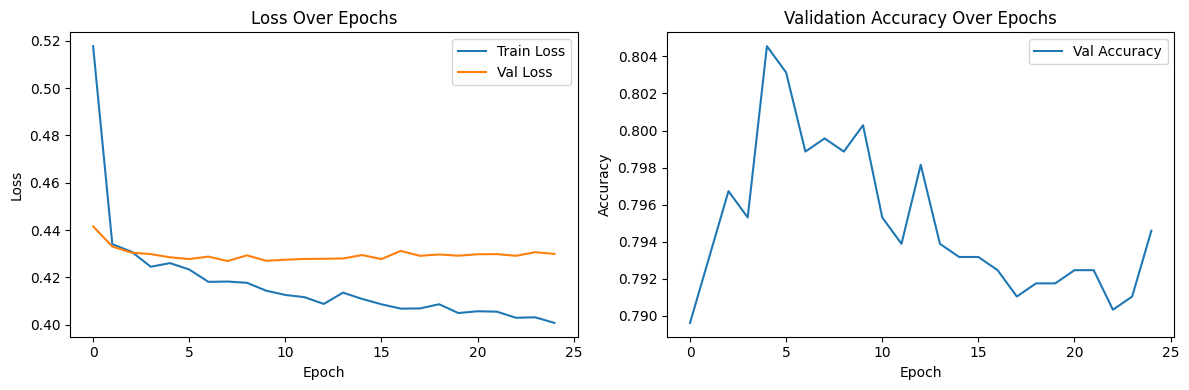

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

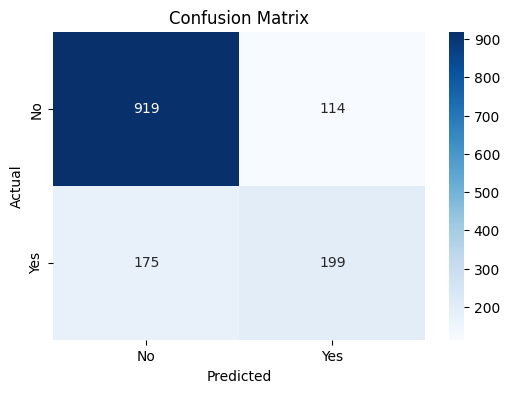

              precision    recall  f1-score   support

          No       0.84      0.89      0.86      1033
         Yes       0.64      0.53      0.58       374

    accuracy                           0.79      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.79      0.79      0.79      1407



In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict on the entire test set
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = (outputs >= 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(all_targets, all_preds, target_names=["No", "Yes"]))